In [16]:
import matplotlib.pyplot as plt
import numpy as np
import util
import xarray as xr
from matplotlib import colors, ticker
from matplotlib.gridspec import GridSpec
from scipy import stats

chunks = {"x": 2000, "ncol": 2000}
t = -13

In [17]:
run = "dpscream_rce_large_3km_lpls304k"
run_dir = f"/glade/derecho/scratch/sturbeville/DPSCREAM_simulations/{run}/run/"
file = run_dir + f"{run}_h0_last5days.nc"
# file = run_dir + f"{run}.eam.h0.2000-02-20-21600.nc"
qsmall=1e-8

In [18]:
plt.rcParams.update({"font.size": 18})  # all to 18 if not specified other

In [19]:
print(file)
# ds = xr.open_dataset(file, chunks=chunks)[["crm_grid_x", "crm_grid_y", "CLDICE", "CLDLIQ", "T"]].isel(time=t)  
ds = xr.open_dataset(file, chunks=chunks).isel(time=t)
x = ds.crm_grid_x
y = ds.crm_grid_y
iwc = ds.CLDICE+ds.CLDLIQ
temp = ds['T']
time = ds.time
# del ds
print(x.shape, y.shape, time.values)

/glade/derecho/scratch/sturbeville/DPSCREAM_simulations/dpscream_rce_large_3km_lpls304k/run/dpscream_rce_large_3km_lpls304k_h0_last5days.nc
(147456,) (147456,) 2000-02-17 00:00:00


In [20]:
# iwc.mean(dim=['ncol'], skipna=True).plot()

In [21]:
np.nansum(x)

23347202000.0

In [22]:
cross_mask = np.where(x < 100, 1, 0)
print(cross_mask.shape)
x0 = x.where(cross_mask)
y0 = y.where(cross_mask)
print(x0.shape, y0.shape)
ncross = np.nansum(cross_mask)
print(ncross)

(147456,)
(147456,) (147456,)
1536


In [23]:
nuc = (
    xr.open_dataset(run_dir + run + "_NUC_hrs.nc").sel(time=time, method="nearest").NUC
)
bcu = (
    xr.open_dataset(run_dir + run + "_BCU_hrs.nc").sel(time=time, method="nearest").BCU
)
z = (
    xr.open_dataset(run_dir + run + "_Z3_mean.nc")
    # xr.open_dataset(run_dir + run + "_Zmean_last5days.nc")
    # .sel(time=time, method="nearest")
    .Z3[0, :, 0, 0]/1000
)
print(time.values, nuc.time.values)
# nuc

2000-02-17 00:00:00 2000-02-17 00:00:00


In [24]:
nuc.shape, bcu.shape, z.shape

((128, 147456), (128, 147456), (128,))

In [25]:
# nuc.plot.hist(bins=np.arange(0, 50))
# plt.show()
# bcu.plot.hist(bins=np.arange(0, 50))
# plt.show()

In [26]:
# plt.scatter(y0/1000, x0)
# plt.show()

In [27]:
# y_plot = np.linspace(0,y[-1].values,ncross)
# print(y_plot.shape)

In [28]:
iwc_plot = iwc.where(cross_mask[np.newaxis, :])
nuc_plot = nuc.where((iwc>qsmall)&(cross_mask[np.newaxis, :]))
bcu_plot = bcu.where((iwc>qsmall)&(cross_mask[np.newaxis, :]))
# cld_plot = (
#     xr.where(bcu_plot<2,1,0) +
#     xr.where(nuc_plot<(bcu_plot-5),2,0) +
#     xr.where(nuc_plot<(bcu_plot-24),1,0) +
#     xr.where((bcu_plot<nuc_plot)&(bcu_plot>=2),4,0)
# )
# cld_plot = cld_plot.where(temp<233.15)
# cld_plot
# iwc_plot.values

In [29]:
y.shape, z.shape, iwc_plot.shape, nuc_plot.shape, bcu_plot.shape#, cld_plot.shape

((147456,), (128,), (128, 147456), (128, 147456), (128, 147456))

In [30]:
# iwc_plot.mean(dim=['ncol'], skipna=True).plot()
y.values

array([0.0000000e+00, 2.7639321e+03, 7.2360679e+03, ..., 5.1172360e+06,
       5.1127640e+06, 5.1172360e+06], dtype=float32)

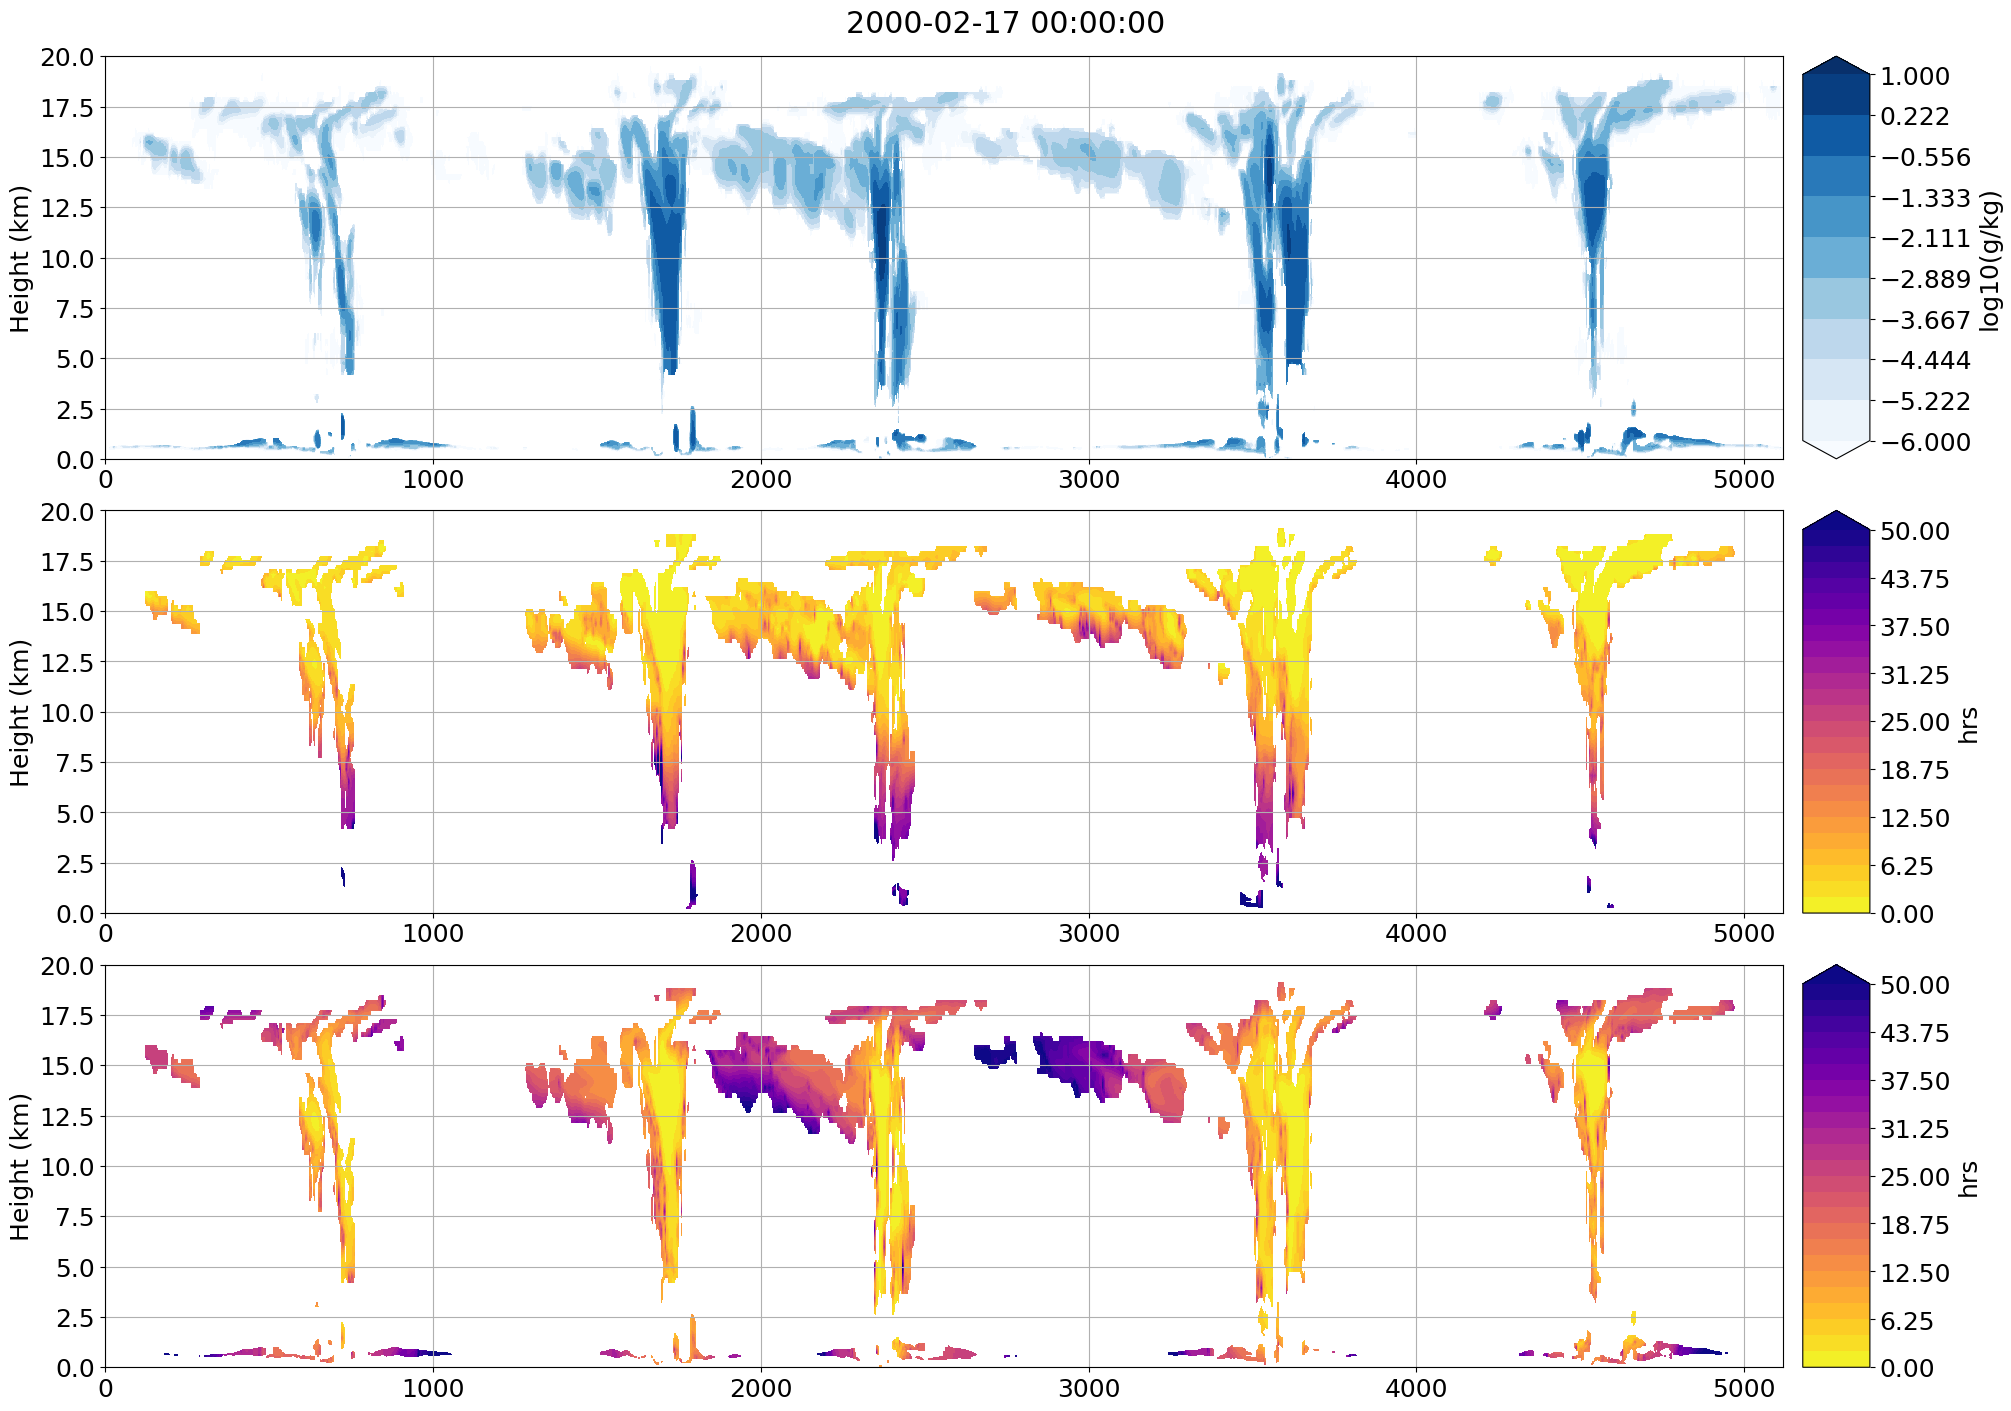

In [31]:
fig = plt.figure(figsize=(20, 14), layout="constrained")
gs = GridSpec(3, 2, figure=fig, width_ratios=[100, 4], hspace=0)
ax0 = fig.add_subplot(gs[0, 0])
cax0 = fig.add_subplot(gs[0, 1])
cf = ax0.contourf(
    y / 1000,
    z,
    np.log10(iwc_plot * 1000),
    levels=np.linspace(-6, 1, 10),
    extend="both",
    cmap="Blues",
)
plt.colorbar(cf, cax=cax0, label="log10(g/kg)")
ax1 = fig.add_subplot(gs[1, 0])
cax1 = fig.add_subplot(gs[1, 1])
cf = ax1.contourf(
    y / 1000,
    z,
    nuc_plot,
    levels=np.linspace(0, 50, 25),
    extend="max",
    cmap="plasma_r",
)
plt.colorbar(cf, cax=cax1, label="hrs")
ax2 = fig.add_subplot(gs[2, 0])
cax2 = fig.add_subplot(gs[2, 1])
cf = ax2.contourf(
    y / 1000,
    z,
    bcu_plot,
    levels=np.linspace(0, 50, 25),
    extend="max",
    cmap="plasma_r",
)
plt.colorbar(cf, cax=cax2, label="hrs")
# ax3 = fig.add_subplot(gs[3, 0])
# cax3 = fig.add_subplot(gs[3, 1])
# cf = ax3.contourf(
#     y / 1000,
#     z / 1000,
#     cld_plot,
#     levels=np.arange(0.5, 4.6, 1),
#     # extend="max",
#     cmap="rainbow",
# )
# cbar = plt.colorbar(cf, cax=cax3, ticks=[1,2,3,4])
# cbar.ax.set_yticklabels(["conv", "in-situ", "remote", "conv ci"])

ax0.set(ylim=[0, 20],  # xlim=[2000,3600],
        ylabel="Height (km)")
ax1.set(ylim=[0, 20],  # xlim=[2000,3600],
        ylabel="Height (km)")
ax2.set(ylim=[0, 20],  # xlim=[2000,3600],
        ylabel="Height (km)")
# ax3.set(ylim=[0, 20],  # xlim=[2000,3600],
#         ylabel="Height (km)", xlabel="x (km)")
ax0.grid(True)
ax1.grid(True)
ax2.grid(True)
# ax3.grid(True)
fig.suptitle(str(nuc.time.values))
plt.savefig(f"../plots/movie/cross_section/cross_section_nucltbcu-5_{run}_{t:04d}.png")
plt.show()